# Benchmarking
This notebook shows the latencies for queries run against a vector database on AstraDB that is prepopulated with data.

In order to run this notebook, you will need a .env file that looks like this:

```
ARIZE_SPACE_ID="...=="
ARIZE_API_KEY="..."

ASTRA_DB_APPLICATION_TOKEN="AstraCS:..."
ASTRA_DB_API_ENDPOINT="https://....apps.astra.datastax.com"
ASTRA_DB_ID="..."

NV_INGEST_URL="..."
NV_RERANK_URL="..."

OPENAI_API_KEY="sk-..."

```

To-do for me is to remove the reranker as necessary.

In [ ]:
import os

from arize.otel import register
from dotenv import load_dotenv
from openinference.instrumentation.langchain import LangChainInstrumentor

from src.python.generate_queries import generate_questions_from_files
from src.python.RagRetriever import RAGRetriever


load_dotenv()


tracer_provider = register(
    space_id = os.getenv("ARIZE_SPACE_ID"),
    api_key =  os.getenv("ARIZE_API_KEY"),
    project_name = "rag-app-notebook",
)
LangChainInstrumentor().instrument(tracer_provider=tracer_provider)


rag_retriever = RAGRetriever(
    collection_name="chunk_size_500",
)


### Question Generation

In [2]:
from llama_index.core.evaluation import EmbeddingQAFinetuneDataset


pdf_dir = "./data/arxiv_papers"
qa_output = "./train_dataset.json"


if not os.path.exists(qa_output):
    questions = generate_questions_from_files(pdf_dir, max_files=20)
questions = list(EmbeddingQAFinetuneDataset.from_json(qa_output).queries.values())


### Execute Queries - Similarity Search + Reranking

In [ ]:
import time
import statistics
import concurrent.futures
import numpy as np
from typing import List, Dict, Any
from tqdm import tqdm

def process_query(rag_retriever, query: str, similarity_top_k: int = 20, rerank_top_n: int = 3) -> Dict[str, Any]:
    """Process a single query and record timing information."""
    start_time = time.time()
    
    results = rag_retriever.similarity_search(query, similarity_top_k=similarity_top_k, rerank_top_n=rerank_top_n)
    
    end_time = time.time()
    time_taken = end_time - start_time
    
    return {
        "query": query,
        "time": time_taken,
        "results": results
    }

def run_concurrent_queries(rag_retriever, queries: List[str], max_workers: int = 4, 
                         similarity_top_k: int = 20, rerank_top_n: int = 3) -> List[Dict[str, Any]]:
    """Run queries concurrently with a progress bar and return timing results."""
    all_results = []
    
    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [
            executor.submit(
                process_query, 
                rag_retriever, 
                query, 
                similarity_top_k, 
                rerank_top_n
            ) for query in queries
        ]
        
        for future in tqdm(
            concurrent.futures.as_completed(futures),
            total=len(futures),
            desc="Processing queries",
            unit="query"
        ):
            try:
                result = future.result()
                all_results.append(result)
            except Exception as e:
                # Just log the error without interrupting the progress bar
                all_results.append({"time": None, "error": str(e)})
    
    return all_results

def calculate_percentiles(times: List[float]) -> Dict[str, float]:
    """Calculate various percentiles of the timing data."""
    percentiles = {
        "p50": np.percentile(times, 50),
        "p75": np.percentile(times, 75),
        "p90": np.percentile(times, 90),
        "p95": np.percentile(times, 95),
        "p99": np.percentile(times, 99),
    }
    return percentiles

max_workers = 4

results = run_concurrent_queries(
    rag_retriever, 
    questions, 
    max_workers=max_workers,
    similarity_top_k=20, 
    rerank_top_n=3
)

query_times = [result["time"] for result in results if result["time"] is not None]


### Statistics - Similarity Search + Reranking

In [4]:
if query_times:
    avg_time = statistics.mean(query_times)
    min_time = min(query_times)
    max_time = max(query_times)
    
    percentiles = calculate_percentiles(query_times)
    
    print("\nQuery Latency Statistics:")
    print("-" * 40)
    print(f"Average: {avg_time:.4f}s")
    print(f"Minimum: {min_time:.4f}s")
    print(f"Maximum: {max_time:.4f}s")
    
    print("\nPercentile Latencies:")
    print(f"p50 (median): {percentiles['p50']:.4f}s")
    print(f"p75: {percentiles['p75']:.4f}s")
    print(f"p90: {percentiles['p90']:.4f}s")
    print(f"p95: {percentiles['p95']:.4f}s")
    print(f"p99: {percentiles['p99']:.4f}s")
    
    if len(query_times) > 1:
        stddev = statistics.stdev(query_times)
        print(f"\nStandard deviation: {stddev:.4f}s")
    
    print(f"\nTotal queries: {len(query_times)}")
    print(f"Failed queries: {len(results) - len(query_times)}")
    
    total_sequential_time = sum(query_times)
    elapsed_wall_time = max(result["time"] for result in results if result["time"] is not None)
    
    print(f"\nTotal sequential processing time: {total_sequential_time:.4f}s")
    print(f"Wall clock time with concurrency: {elapsed_wall_time:.4f}s")
    print(f"Speedup from concurrency: {total_sequential_time / elapsed_wall_time:.2f}x")


Query Latency Statistics:
----------------------------------------
Average: 0.3938s
Minimum: 0.1697s
Maximum: 5.4992s

Percentile Latencies:
p50 (median): 0.3263s
p75: 0.3820s
p90: 0.5029s
p95: 0.6362s
p99: 2.1884s

Standard deviation: 0.4028s

Total queries: 522
Failed queries: 0

Total sequential processing time: 205.5397s
Wall clock time with concurrency: 5.4992s
Speedup from concurrency: 37.38x


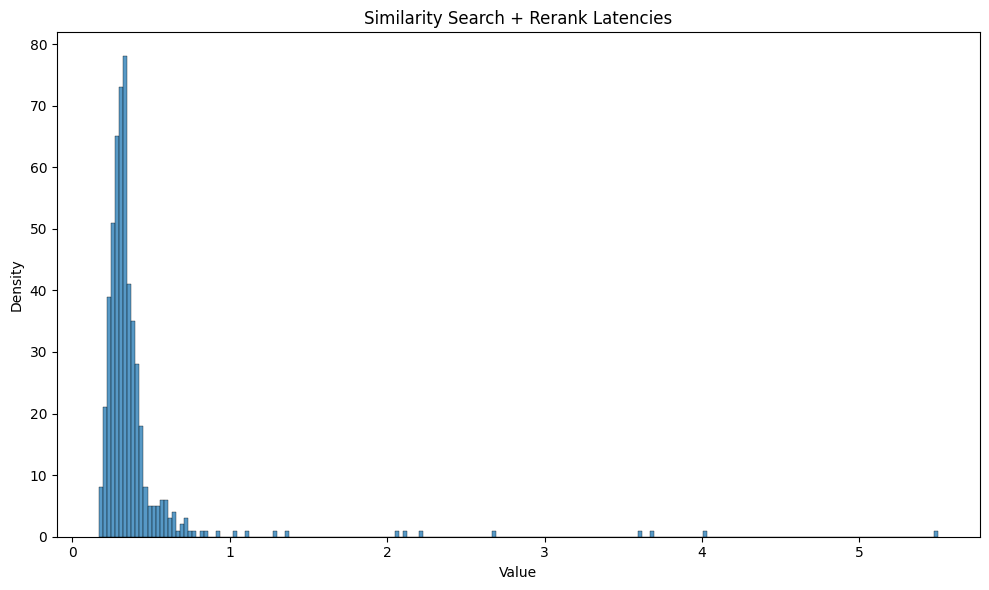

In [5]:
%matplotlib inline
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
sns.histplot(data=query_times)

plt.title('Similarity Search + Rerank Latencies')
plt.xlabel('Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

### Execute Queries - Similarity Search

In [ ]:
import time
import statistics
import concurrent.futures
import numpy as np
from typing import List, Dict, Any
from tqdm import tqdm

def process_query(rag_retriever, query: str, similarity_top_k: int = 20, rerank_top_n: int = 3) -> Dict[str, Any]:
    """Process a single query and record timing information."""
    start_time = time.time()
    
    results = rag_retriever.get_relevant_documents(query)
    
    end_time = time.time()
    time_taken = end_time - start_time
    
    return {
        "query": query,
        "time": time_taken,
        "results": results
    }

def run_concurrent_queries(rag_retriever, queries: List[str], max_workers: int = 4, 
                         similarity_top_k: int = 20, rerank_top_n: int = 3) -> List[Dict[str, Any]]:
    """Run queries concurrently with a progress bar and return timing results."""
    all_results = []
    
    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [
            executor.submit(
                process_query, 
                rag_retriever, 
                query, 
                similarity_top_k, 
                rerank_top_n
            ) for query in queries
        ]
        
        for future in tqdm(
            concurrent.futures.as_completed(futures),
            total=len(futures),
            desc="Processing queries",
            unit="query"
        ):
            try:
                result = future.result()
                all_results.append(result)
            except Exception as e:
                # Just log the error without interrupting the progress bar
                all_results.append({"time": None, "error": str(e)})
    
    return all_results

def calculate_percentiles(times: List[float]) -> Dict[str, float]:
    """Calculate various percentiles of the timing data."""
    percentiles = {
        "p50": np.percentile(times, 50),
        "p75": np.percentile(times, 75),
        "p90": np.percentile(times, 90),
        "p95": np.percentile(times, 95),
        "p99": np.percentile(times, 99),
    }
    return percentiles

max_workers = 4

results = run_concurrent_queries(
    rag_retriever, 
    questions, 
    max_workers=max_workers,
    similarity_top_k=20, 
    rerank_top_n=3
)

query_times = [result["time"] for result in results if result["time"] is not None]


### Statistics - Similarity Search

In [7]:
if query_times:
    avg_time = statistics.mean(query_times)
    min_time = min(query_times)
    max_time = max(query_times)
    
    percentiles = calculate_percentiles(query_times)
    
    print("\nQuery Latency Statistics:")
    print("-" * 40)
    print(f"Average: {avg_time:.4f}s")
    print(f"Minimum: {min_time:.4f}s")
    print(f"Maximum: {max_time:.4f}s")
    
    print("\nPercentile Latencies:")
    print(f"p50 (median): {percentiles['p50']:.4f}s")
    print(f"p75: {percentiles['p75']:.4f}s")
    print(f"p90: {percentiles['p90']:.4f}s")
    print(f"p95: {percentiles['p95']:.4f}s")
    print(f"p99: {percentiles['p99']:.4f}s")
    
    if len(query_times) > 1:
        stddev = statistics.stdev(query_times)
        print(f"\nStandard deviation: {stddev:.4f}s")
    
    print(f"\nTotal queries: {len(query_times)}")
    print(f"Failed queries: {len(results) - len(query_times)}")
    
    total_sequential_time = sum(query_times)
    elapsed_wall_time = max(result["time"] for result in results if result["time"] is not None)
    
    print(f"\nTotal sequential processing time: {total_sequential_time:.4f}s")
    print(f"Wall clock time with concurrency: {elapsed_wall_time:.4f}s")
    print(f"Speedup from concurrency: {total_sequential_time / elapsed_wall_time:.2f}x")



Query Latency Statistics:
----------------------------------------
Average: 0.3456s
Minimum: 0.1758s
Maximum: 5.4267s

Percentile Latencies:
p50 (median): 0.2895s
p75: 0.3534s
p90: 0.4326s
p95: 0.5334s
p99: 1.2019s

Standard deviation: 0.3560s

Total queries: 522
Failed queries: 0

Total sequential processing time: 180.3839s
Wall clock time with concurrency: 5.4267s
Speedup from concurrency: 33.24x


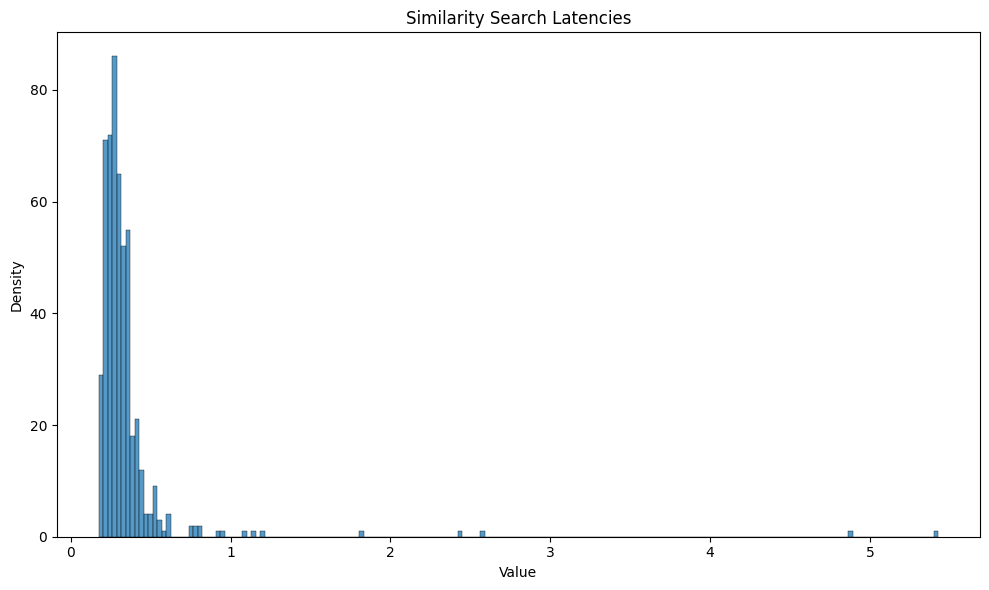

In [8]:
%matplotlib inline
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
sns.histplot(data=query_times)

plt.title('Similarity Search Latencies')
plt.xlabel('Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()